In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
# sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/tweet_csv/trad/220124_trad.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df = df.drop("author_id", axis=1)
df = df.drop("username", axis=1)
# df = df.drop("tweet_id", axis=1)
df = df.drop("like_count", axis=1)
df = df.drop("retweet_count", axis=1)
df

,created_at,text
0,2022-01-24 15:00:00,#THETRAD
1,2022-01-24 15:00:01,#THETRAD
2,2022-01-24 15:00:01,１５時！ #tokyofm #THETRAD
3,2022-01-24 15:00:01,#THETRAD
4,2022-01-24 15:00:01,#THETRAD
...,...,...
2012,2022-01-24 16:53:31,あー、吾郎さんの ラジオジャックの1日が 終わった〜❣️ まだまだ足りない〜😝 けど… ま、...
2013,2022-01-24 16:53:59,吾郎さんのスペシャルラジオデー終わった。 楽しかった。それぞれ少しずつ違う吾郎さんを楽しめま...
2014,2022-01-24 16:54:40,吾郎店長、午前も午後もラジオ番組の 生出演お疲れ様でした。 楽しかったです♪また明日〜。 ...
2015,2022-01-24 16:54:40,この時間は家族の邪魔が入ってすんなり聴けない😂 ミポリンのC、懐かしい〜！ 毎度お騒がせも...


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、し│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-24 15:00:00,
1,2022-01-24 15:00:01,
2,2022-01-24 15:00:01,0時
3,2022-01-24 15:00:01,
4,2022-01-24 15:00:01,
...,...,...
2012,2022-01-24 16:53:31,あー吾郎さんのラジオジャックの0日が終わったまだまだ足りないけどま明日もあるかc u tom...
2013,2022-01-24 16:53:59,吾郎さんのスペシャルラジオデー終わった楽かったそれぞれ少ずつ違う吾郎さんを楽めまた
2014,2022-01-24 16:54:40,吾郎店長午前も午後もラジオ番組の生出演お疲れ様でた楽かったです♪また明日
2015,2022-01-24 16:54:40,この時間は家族の邪魔が入ってすんなり聴けないミポリンのc懐かい毎度お騒がせも夢で逢えたらも絶...


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-24 15:00:00,,0
1,2022-01-24 15:00:01,,0
2,2022-01-24 15:00:01,0時,[0時]
3,2022-01-24 15:00:01,,0
4,2022-01-24 15:00:01,,0
...,...,...,...
2012,2022-01-24 16:53:31,あー吾郎さんのラジオジャックの0日が終わったまだまだ足りないけどま明日もあるかc u tom...,"[吾郎さん, ラジオジャック, 0, 日, 終わっ, まだまだ, 足り, 明日, ある, c..."
2013,2022-01-24 16:53:59,吾郎さんのスペシャルラジオデー終わった楽かったそれぞれ少ずつ違う吾郎さんを楽めまた,"[吾郎さん, スペシャルラジオデー, 終わっ, 楽, かっ, それぞれ, 少, 違う, 吾郎..."
2014,2022-01-24 16:54:40,吾郎店長午前も午後もラジオ番組の生出演お疲れ様でた楽かったです♪また明日,"[吾郎, 店長, 午前, 午後, ラジオ番組, 生出演, で, 楽, かっ, 明日]"
2015,2022-01-24 16:54:40,この時間は家族の邪魔が入ってすんなり聴けないミポリンのc懐かい毎度お騒がせも夢で逢えたらも絶...,"[時間, 家族, 邪魔, 入っ, すんなり, 聴け, ミポリン, c, 懐, 毎度, 騒がせ..."


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-24 15:00:00,"[0時, 始まっ, 久, ぶり, 聞き, 少, 今週, open, てこ, ダレハナ, なだ..."
1,2022-01-24 15:01:00,"[the, trad, tokyo, fm, the, trad, tokyo, fm, レ..."
2,2022-01-24 15:02:00,"[臨時, 特別, 店員, れな, ちさ, やっ, ほ, ー, 吉田, くん, ただい, まそ..."
3,2022-01-24 15:03:00,"[始まっ, 店内, 出汁, 匂い, て, さっき, トーク, 聴か, れ, て, ちょっと,..."
4,2022-01-24 15:04:00,"[できっこないをやらなくちゃ, ー, れな, ち, 吾郎, 店長, 吉田, 店員, 吉田, ..."
...,...,...
110,2022-01-24 16:50:00,"[名古屋, トレンド, top, 0, bot, 0, 年, 0, 月, 0, 日, 0時,..."
111,2022-01-24 16:51:00,"[きつね, 誰, 吾郎, 店長, 明日, 吾郎, 店長, 目, 見, 話, の, 初めて, ..."
112,2022-01-24 16:52:00,"[黒沢, さん, 吾郎さん, お話, でき, 嬉, そう, 楽, そう, の, すごく, 伝..."
113,2022-01-24 16:53:00,"[気, 取り, てこ, こね, メッセージ, 無心, なれる, 大事, 事, 脳科学, 中野..."


In [8]:
# df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
110    None
111    None
112    None
113    None
114    None
Length: 115, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-24 15:00:00,0
1,2022-01-24 15:00:01,0
2,2022-01-24 15:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2022-01-24 15:00:01,0
4,2022-01-24 15:00:01,0
...,...,...
2012,2022-01-24 16:53:31,"[-0.5082194, 0.2576332, -0.2920187, -0.4667443..."
2013,2022-01-24 16:53:59,"[0.00044748187, 0.72796905, 0.09976469, 0.0778..."
2014,2022-01-24 16:54:40,"[0.76183164, 0.04768083, 0.40473068, -0.247872..."
2015,2022-01-24 16:54:40,"[-0.27137724, -0.2780047, -0.28387773, -1.0655..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-24 15:00:00,"[0, 0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,2022-01-24 15:01:00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2022-01-24 15:02:00,"[[-0.4857578, 0.106532805, 0.4128779, -0.93168..."
3,2022-01-24 15:03:00,"[[1.3368078, 1.051961, -1.1891502, 3.772901, 0..."
4,2022-01-24 15:04:00,"[[-0.25918388, -1.3847544, 1.2819421, -0.25139..."
...,...,...
110,2022-01-24 16:50:00,"[[-0.86005086, 0.46078834, -0.27936438, 0.6888..."
111,2022-01-24 16:51:00,"[[-0.6881902, 1.0310606, -0.06396583, 0.115972..."
112,2022-01-24 16:52:00,"[[0.13145278, -0.03362645, -0.61352396, -0.256..."
113,2022-01-24 16:53:00,"[[0.27708408, 0.1805608, -0.30032283, -1.03173..."


In [13]:
df_vectors.to_csv('vectors.csv', index=False)

In [14]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [15]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-24 15:00:00,-0.028331,0.124631,0.253465,0.116332,0.163341
1,2022-01-24 15:01:00,-0.049433,0.056712,0.183684,0.091853,0.203616
2,2022-01-24 15:02:00,0.128704,0.231293,0.352738,0.254596,0.183213
3,2022-01-24 15:03:00,0.200434,0.326667,0.479376,0.339172,0.208960
4,2022-01-24 15:04:00,0.170930,0.308371,0.448389,0.320977,0.210523
...,...,...,...,...,...,...
110,2022-01-24 16:50:00,0.403868,0.513804,0.639662,0.485288,0.191188
111,2022-01-24 16:51:00,0.413061,0.547814,0.634036,0.533256,0.172432
112,2022-01-24 16:52:00,0.443726,0.538274,0.627100,0.534908,0.131697
113,2022-01-24 16:53:00,0.446267,0.467909,0.597249,0.508164,0.110859


In [16]:
df_vectors.to_csv('similarity.csv', index=False)


In [17]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/word2vec/220124_trad/count.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60 +1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,-0.028331,0.124631,0.253465,0.116332,0.163341,29
1,2,-0.049433,0.056712,0.183684,0.091853,0.203616,15
2,3,0.128704,0.231293,0.352738,0.254596,0.183213,53
3,4,0.200434,0.326667,0.479376,0.339172,0.208960,57
4,5,0.170930,0.308371,0.448389,0.320977,0.210523,90
...,...,...,...,...,...,...,...
110,111,0.403868,0.513804,0.639662,0.485288,0.191188,10
111,112,0.413061,0.547814,0.634036,0.533256,0.172432,18
112,113,0.443726,0.538274,0.627100,0.534908,0.131697,18
113,114,0.446267,0.467909,0.597249,0.508164,0.110859,5


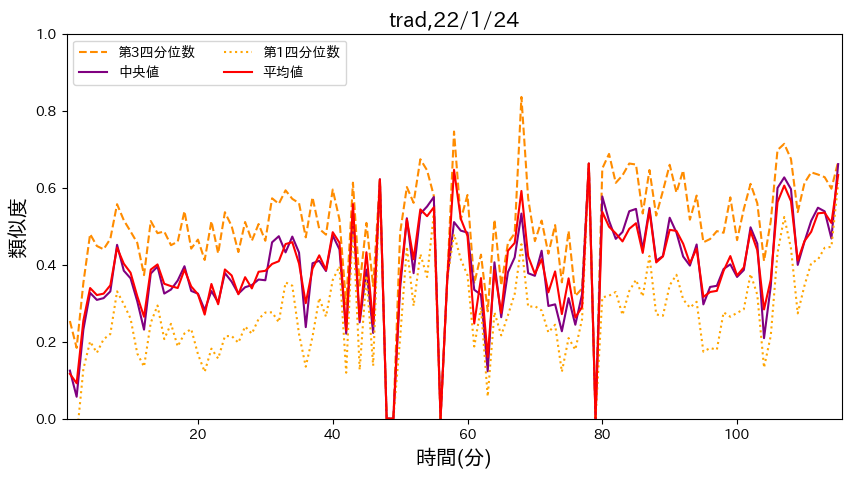

In [18]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "trad,22/1/24", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均値")
    ax.legend(loc="upper left",  ncol=2)
    plt.savefig('quantile.png')


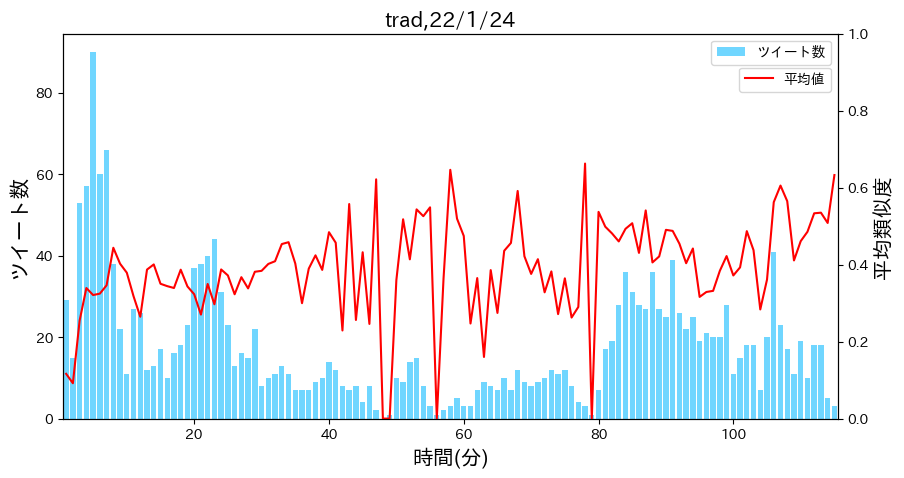

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "trad,22/1/24", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均類似度", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('mean.png')


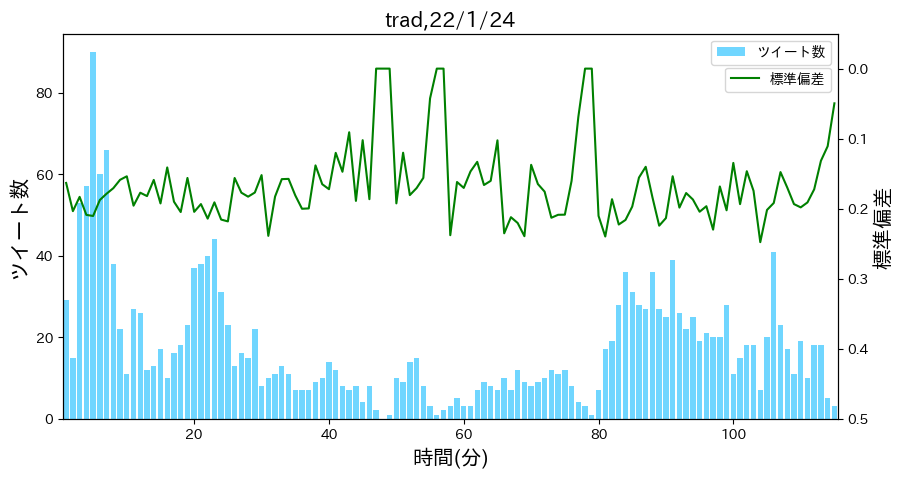

In [20]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(
        "trad,22/1/24", fontsize=15)
    # indices = range(0, len(df_vectors), 10)
    # plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.05)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.93))
    plt.savefig('stdev.png')
